 # <h1 style='background:#F7B2B0; border:0; color:black'><center>UNETR: Transformers for 3D Medical Image Segmentation</center></h1> 

This notebook is the first ever implementation of the paper in TensorFlow

UNETR Paper : https://arxiv.org/pdf/2103.10504.pdf

Fully Convolutional neural networks have been used predominantly in medical image segmentation since the past decade. Despite their success, locality of convolutional layers limits their learning capacity of long- range spatial dependencies. Long-range spatial is the rate of decay of statistical dependence of two points with increasing time intervals or spatial distance between the points.UNETR uses a transformer as the encoder to learn sequence representations of the input volume and capture the global multi-scale information, following the “U-shaped” network design for the encoder and decoder. The transformer encoder is directly connected to a decoder via skip connections at different resolutions to compute the final semantic segmentation output.

The performance of UNETR has been evaluated on the Multi Atlas Labelling Beyond The Cranial Vault (BTCV) dataset for multiorgan segmentation and the Medical Segmentation Decathlon (MSD) dataset for brain tumour and spleen segmentation tasks. The benchmarks demonstrate new state-of-the-art performance on the BTCV leaderboard. 

### Introduction

<div class="alert alert-block alert-info">  

FCNN and “U-shaped” encoder- decoder architecture have achieved state-of-the-art results in medical semantic segmentation tasks. However, their performance in learning long-range dependencies is limited to their localised receptive fields. This leads to sub-optimal segmentation of structures with variable shapes and scales (e.g. brain lesions with different sizes).

From the success of transformers in NLP, we know that due to their flexible formulation, they can effectively learn long-range information. 
The 3D image segmentation task has been reformulated as  a 1D sequence-to-sequence prediction problem and uses a transformer as the encoder to learn contextual information from the embedded input patches. The extracted representations from the transformer encoder are merged with the CNN-based decoder via skip connections at multiple resolutions to predict the segmentation outputs. Instead of using transformers in the decoder, UNETR uses a CNN-based decoder. 

The effectiveness of UNETR  on 3D CT and MRI segmentation tasks has been validated using Beyond the Cranial Vault (BTCV) and Medical Segmentation Decathlon (MSD) datasets.

</div>

![](https://i.imgur.com/Pqmf8tN.png)

### Related work

**CNN-based Segmentation Networks :** 
 CNN has achieved state-of-the-art results on various 2D and 3D medical image segmentation tasks. For volume-wise segmentation, tri-planar architectures are sometimes used to combine three-view slices for each voxel, also known for 2.5D methods. In contrast, 3D approaches directly utilize the full volumetric image represented by a sequence of 2D slices or modalities.  

These methods provide pioneer studies of 3D medical image segmentation at multiple levels, which reduces problems in spatial context and low-resolution condition. A limitation of these networks is their poor performance in learning global context and long-range spatial dependencies, which can severely impact the segmentation performance

**Vision Transformers :**

In computer vision, they demonstrated state-of-the-art performance on image classification datasets by large-scale pre-training and fine-tuning of a pure transformer. Recently, hierarchical vision transformers with varying resolutions and spatial embeddings have been proposed. These methodologies gradually decrease the resolution of features in the transformer layers and utilise sub-sampled attention modules. 


In [1]:

import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf
import re
import math
import cv2
import matplotlib.pyplot as plt
from glob import glob
from kaggle_datasets import KaggleDatasets

from PIL import Image
from tqdm import tqdm
import wandb
import glob

import math
import tensorflow as tf
import tensorflow.keras.backend as k

import os
from typing import List, Tuple
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from skimage import io
from skimage.color import gray2rgb
from skimage.transform import resize
from rich.jupyter import print

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("api_key")
wandb.login(key = wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **<span style="color:#F7B2B0;">Data Preprocessing</span>**

In [3]:
# Code copied from https://www.kaggle.com/code/ayuraj/quick-data-eda-segmentation-viz-using-w-b

ROOT_DIR = '../input/uw-madison-gi-tract-image-segmentation/'
df = pd.read_csv(ROOT_DIR+'train.csv')
# Remove rows with NaN Segmentation masks
df = df[df.segmentation.notna()].reset_index(drop=False)
def get_case_str(row):
    case_num = row.id.split('_')[0]
    return case_num

def get_case_id(row):
    case_num = row.id.split('_')[0]
    return int(case_num[4:])

df['case_str'] = df.apply(lambda row: get_case_str(row), axis=1)
df['case_id'] = df.apply(lambda row: get_case_id(row), axis=1)

def get_day_str(row):
    return row.id.split('_')[1]

def get_day_id(row):
    return int(row.id.split('_')[1][3:])

df['day_str'] = df.apply(lambda row: get_day_str(row), axis=1)
df['day_id'] = df.apply(lambda row: get_day_id(row), axis=1)

def get_slice_str(row):
    slice_id = row.id.split('_')[-1]
    return f'slice_{slice_id}'

df['slice_str'] = df.apply(lambda row: get_slice_str(row), axis=1)
filepaths = glob.glob(ROOT_DIR+'train/*/*/*/*')


file_df = pd.DataFrame(columns=['case_str', 'day_str', 'slice_str', 'filename', 'filepath'])
for idx, filepath in tqdm(enumerate(filepaths)):
    case_day_str = filepath.split('/')[5]
    case_str, day_str = case_day_str.split('_')

    filename = filepath.split('/')[-1]
    slice_id = filename.split('_')[1]
    slice_str = f'slice_{slice_id}'
    
    file_df.loc[idx] = [case_str, day_str, slice_str, filename, filepath]

df = pd.merge(df, file_df, on=['case_str', 'day_str', 'slice_str'])

def get_image_height(row):
    return int(row.filename[:-4].split('_')[2])
    
def get_image_width(row):
    return int(row.filename[:-4].split('_')[3])

def get_pixel_height(row):
    return float(row.filename[:-4].split('_')[4])

def get_pixel_width(row):
    return float(row.filename[:-4].split('_')[5])

df['img_height'] = df.apply(lambda row: get_image_height(row), axis=1)
df['img_width'] = df.apply(lambda row: get_image_width(row), axis=1)
df['pixel_height (mm)'] = df.apply(lambda row: get_pixel_height(row), axis=1)
df['pixel_width (mm)'] = df.apply(lambda row: get_pixel_width(row), axis=1)

df.drop('index', axis=1, inplace=True)

by_case = df.groupby('case_str')
case_df = by_case.get_group('case123')

by_day = case_df.groupby('day_str')
day_df = by_day.get_group('day0')

by_slice = day_df.groupby('slice_str')
slice_df = by_slice.get_group('slice_0075')

# saving the dataframe
df.to_csv('df.csv')
# saving the dataframe
slice_df.to_csv('slice_df.csv')

38496it [02:10, 295.03it/s]


# **<span style="color:#F7B2B0;">W & B Artifacts</span>**

An artifact as a versioned folder of data.Entire datasets can be directly stored as artifacts .

W&B Artifacts are used for dataset versioning, model versioning . They are also used for tracking dependencies and results across machine learning pipelines.Artifact references can be used to point to data in other systems like S3, GCP, or your own system.

You can learn more about W&B artifacts [here](https://docs.wandb.ai/guides/artifacts)

![](https://drive.google.com/uc?id=1JYSaIMXuEVBheP15xxuaex-32yzxgglV)

In [4]:
# Save training data to W&B Artifacts
run = wandb.init(project='UW-Madison-Viz', name='processed_data') 
artifact = wandb.Artifact(name='processed_data',type='dataset')
artifact.add_file("./df.csv")
artifact.add_file("./slice_df.csv")
wandb.log_artifact(artifact)
wandb.finish()

wandb: Currently logged in as: usharengaraju. Use `wandb login --relogin` to force relogin


![](https://i.imgur.com/cYkCWRg.png)

# **<span style="color:#F7B2B0;">Visualizing Random Samples</span>**


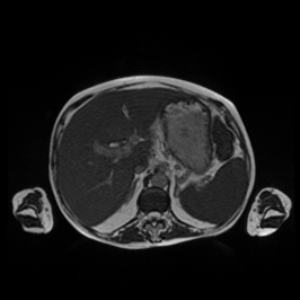
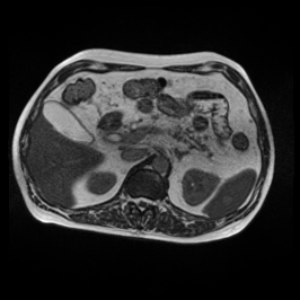
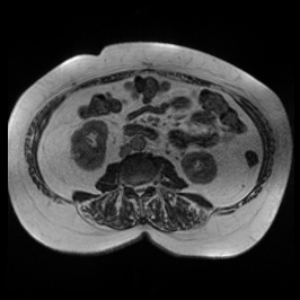
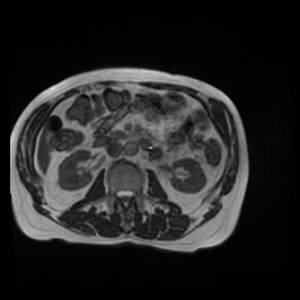
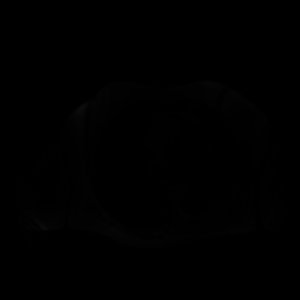

In [5]:
# Code copied from https://www.kaggle.com/code/bsridatta/eda-for-a-healthy-gi-tract

# load flattened metadata
train_df = pd.read_csv("/kaggle/input/uwmadison-flattened-metadata/train_flat.csv")
train_path = Path("/kaggle/input/uw-madison-gi-tract-image-segmentation/train/")

def get_image_array(file_paths: List[str], 
                    image_folder:str="/kaggle/input/uw-madison-gi-tract-image-segmentation/train/", 
                    shape: Tuple=(300,300)
                   ) -> np.array:
    """read all images as a single array for plotly."""
    read_img = lambda file: io.imread(f"{image_folder}/{file}")
    images = []
    empty = 0
    for x in file_paths:
        img = read_img(x)
        images.append(resize(img, shape))
        if not img.any():
            empty += 1
    # print(f"{empty} images are blank")
    return np.asarray(images)

def parse_paths(ids: List[str], image_files: List[str]) -> List[str]:
    paths = []
    for id, file in zip(ids, image_files):
        splits = id.split("_")
        paths.append(f"{splits[0]}/{splits[0]}_{splits[1]}/scans/{file}")
    return paths

save_path = Path("/kaggle/working/")

samples = train_df[['id', 'image_file']].sample(5, random_state=400)
sample_paths = parse_paths(samples.id.values, samples.image_file.values)
sample_images = get_image_array(sample_paths)

# plot image grid
fig = px.imshow(sample_images, facet_col=0, binary_string=True, facet_row_spacing=0.0, facet_col_spacing=0)
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

# add species name and individual_id
for i, a in enumerate(fig.layout.annotations):
    a.text = samples.iloc[i].id
fig.update_layout(title=f"Random Samples", autosize=True, hovermode=False, height=400, width=1200, margin=dict(l=40, r=0, t=140, b=80))
fig.show()

# **<span style="color:#F7B2B0;">Visualize Segmentation Masks using W&B</span>**


In [6]:
filepath = slice_df.filepath.values[0]
image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

def rle2mask(rles, class_names, height, width, class_dict):
    img = np.zeros(height*width, dtype=np.uint16)
    for rle, class_name in zip(rles, class_names):
        s = rle.split(' ')
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = class_dict[class_name]
        
    mask = img.reshape((width, height))
    return mask

class2id = {class_name: idx+1 for idx, class_name in enumerate(df['class'].unique())} # 0 is reserved for background
id2class = {v:k for k, v in class2id.items()}

mask = rle2mask(slice_df.segmentation.values,
                slice_df['class'].values,
                slice_df.img_height.values[0],
                slice_df.img_width.values[0],
                class2id)



In [7]:
# 1. Generate a dict of mask data to log
wandb_mask = {
    'gt_mask':{
        'mask_data': mask,
        'class_labels': id2class
    }
}

run = wandb.init(project='UW-Madison-Viz')
wandb.log({'Ground Truth Segmentation': wandb.Image(image, masks=wandb_mask)})
wandb.finish()
run

![](https://i.imgur.com/IocKRfx.png)

# **<span style="color:#F7B2B0;">Visualize a case day-wise using W&B Tables</span>**


In [8]:
# A dict with key id and name for logging segmentation mask as W&B Tables.
wandb_class_set = wandb.Classes([{
                     'id': id,
                     'name': name
                  } for id, name in id2class.items()])

for day, day_df in by_day:
    print('The day the scan was taken: ', day)
    
    # 1. Initialize a W&B Run
    run = wandb.init(project='UW-Madison-Viz', group='case123-viz')

    # 2. Initialize a W&B Table
    data_at = wandb.Table(columns=['slice', 'image'])
    
    # Group by slice
    by_slice = day_df.groupby('slice_str')
    
    # Iterate through each slice, open the image, and get mask
    for slice_num, slice_df in tqdm(by_slice):
        # Open the image
        filepath = slice_df.filepath.values[0]
        image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        image = tf.convert_to_tensor(image, dtype=tf.uint16)
        image = tf.image.convert_image_dtype(image, dtype=tf.float16)
        
        # Get mask
        mask = rle2mask(slice_df.segmentation.values,
                slice_df['class'].values,
                slice_df.img_height.values[0],
                slice_df.img_width.values[0],
                class2id)
        
        # 3. Generate a dict of mask data to log
        wandb_mask = {
            'gt_mask':{
                'mask_data': mask,
                'class_labels': id2class
            }
        }
        
        # 4. Add the data as a new row
        data_at.add_data(
            slice_num,
            wandb.Image(image, masks=wandb_mask, classes=wandb_class_set)
        )
        
    # 5. Log the table onto W&B dashboard
    wandb.log({f'Segmentation Viz {day}': data_at})

    # 6. Close the W&B run
    wandb.finish()

The day the scan was taken:  day0

  0%|          | 0/65 [00:00<?, ?it/s]2022-06-25 00:09:06.272597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:09:06.278042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:09:06.278758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 00:09:06.281832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild 

The day the scan was taken:  day20

100%|██████████| 54/54 [00:01<00:00, 35.79it/s]


The day the scan was taken:  day22

100%|██████████| 62/62 [00:01<00:00, 39.85it/s]


![](https://i.imgur.com/GVsxPGK.png)

In [9]:
class CFG:

    debug = False   
   
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Seeding for reproducibility
    seed = 101

    # Image Size
    img_size = [96, 96]

    # Batch Size & Epochs
    batch_size = 2
    drop_remainder = False
    epochs = 15
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "dice_loss"
    optimizer = "Adam"
    lr = 5e-4
    lr_schedule = "CosineDecay"
    patience = 5
   
    # Clip values to [0, 1]
    clip = False
    
AUTO = tf.data.experimental.AUTOTUNE

import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [10]:
BASE_PATH = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
GCS_PATH = KaggleDatasets().get_gcs_path('uwmgi-25d-tfrecord-dataset')
ALL_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/uwmgi/*.tfrec')
print('NUM TFRECORD FILES: {:,}'.format(len(ALL_FILENAMES)))
print('NUM TRAINING IMAGES: {:,}'.format(count_data_items(ALL_FILENAMES)))

2022-06-25 00:09:48.238016: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


NUM TFRECORD FILES: 40

NUM TRAINING IMAGES: 38,208

# **<span style="color:#F7B2B0;">Input Data Pipeline</span>**

In [11]:
# Decode image from bytestring to tensor
def decode_image(data, height, width, target_size=CFG.img_size):
    img = tf.io.decode_raw(data, out_type=tf.uint16)
    img = tf.reshape(img, [height, width, 3])  # explicit size needed for TPU
    img = tf.cast(img, tf.float32)
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))  # scale image to [0, 1]
    img = tf.image.resize_with_pad(
        img, target_size[0], target_size[1], method="nearest"
    )  # resize with pad to avoid distortion
    img = tf.reshape(img, [*target_size, 3])  # reshape after resize
    return img


# Decode mask from bytestring to tensor
def decode_mask(data, height, width, target_size=CFG.img_size):
    msk = tf.io.decode_raw(data, out_type=tf.uint8)
    msk = tf.reshape(msk, [height, width, 3])  # explicit size needed for TPU
    msk = tf.cast(msk, tf.float32)
    msk = msk / 255.0  # scale mask data to[0, 1]
    msk = tf.image.resize_with_pad(
        msk, target_size[0], target_size[1], method="nearest"
    )
    msk = tf.reshape(msk, [*target_size, 3])  # reshape after resize
    return msk


# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, dim=CFG.img_size):
    tfrec_format = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(
        example, tfrec_format
    )  # parses a single example proto.
    image_id = example["id"]
    height = example["height"]
    width = example["width"]
    img = decode_image(example["image"], height, width, dim)  # access image
    msk = decode_mask(example["mask"], height, width, dim)  # access mask
    img = tf.reshape(img, [*dim, 3])
    msk = tf.reshape(msk, [*dim, 3])
    img = tf.repeat(img[:, :, np.newaxis,:], 96, axis=2)
    msk = tf.repeat(msk[:, :, np.newaxis,:], 96, axis=2)
    return (img, msk) if not return_id else (img, image_id, msk)

def get_dataset(
    filenames,
    shuffle=False,
    repeat=False,
    augment=False,
    cache=False,
    return_id=False,
    batch_size=CFG.batch_size ,
    target_size=CFG.img_size,
    drop_remainder=False,
    seed=CFG.seed,
):
    dataset = tf.data.TFRecordDataset(filenames)  # read tfrecord files
    dataset = dataset.map(
        lambda x: read_tfrecord(
            x,
            augment=augment,  # unparse tfrecord data with masks
            return_id=return_id,
            dim=target_size,
        ))
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)  # batch the data
    dataset = dataset.prefetch(AUTO)  # prefetch data for speedup
    return dataset

ds = get_dataset(ALL_FILENAMES, augment=False, cache=False, repeat=False)

# **<span style="color:#F7B2B0;">Model Architecture</span>**


![](https://i.imgur.com/eUyPwD0.png)

<div class="alert alert-block alert-info">  

UNETR uses a contracting-expanding pattern consisting of a stack of transformers as the encoder which is connected to a decoder via skip connections. 1D sequence of a 3D input volume x ∈ R^(H×W×D×C) is created with resolution (H,W,D) and C input channels and divide it into flattened uniform non-overlapping patches xv ∈R^(N×(P^3 .C)) where (P, P, P) denotes the resolution of each patch and N = (H×W ×D)/P^3 is the length of the sequence.Then the patches are projected into a K dimensional embedding space using a linear layer and add 1D positional embedding to it. After embeddings a stack of transformer blocks consisting of multi-head self-attention (MSA) and multilayer perceptron (MLP) sublayers are used.
    
</div>

# **<span style="color:#F7B2B0;">CNN Blocks</span>**


In [12]:
class SingleDeconv3DBlock(tf.keras.layers.Layer):

    def __init__(self,filters):
        super(SingleDeconv3DBlock, self).__init__()
        self.block = tf.keras.layers.Conv3DTranspose(filters= filters, 
                                                     kernel_size=2, strides=2, 
                                                     padding="valid", 
                                                     output_padding=None)
                                                     

    def call(self, inputs):        
        return self.block(inputs)



class SingleConv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size):
        super(SingleConv3DBlock, self).__init__()
        self.kernel=kernel_size
        self.res = tuple(map(lambda i: (i - 1)//2, self.kernel))
        self.block = tf.keras.layers.Conv3D(filters= filters, 
                                            kernel_size=kernel_size, 
                                            strides=1, 
                                            padding='same')

    def call(self, inputs):
        return self.block(inputs)
    
class Conv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size=(3,3,3)):
        super(Conv3DBlock, self).__init__()
        self.a= tf.keras.Sequential([
                                     SingleConv3DBlock(filters,kernel_size=kernel_size),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Activation('relu')
        ])
        

    def call(self, inputs):
        return self.a(inputs)
    
class Deconv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size=(3,3,3)):
        super(Deconv3DBlock, self).__init__()
        self.a= tf.keras.Sequential([
                                     SingleDeconv3DBlock(filters=filters),
                                     SingleConv3DBlock(filters=filters,kernel_size=kernel_size),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Activation('relu')
        ])
  
    def call(self, inputs):
        return self.a(inputs)
    


<div class="alert alert-block alert-info">  

MLP comprises two linear layers with GELU activation functions, i is the intermediate block identifier, and L is the number of transformer layers.A MSA sublayer comprises parallel self-attention (SA) heads. The SA block is a parameterized function that learns the mapping between a query (q) and the corresponding key (k) and value (v) representations in a sequence. The attention weights (A) are computed by measuring the similarity between two elements in z and their key-value pairs using softmax function. 
    
</div>


# **<span style="color:#F7B2B0;">Self Attention and MLP</span>**

In [13]:
class SelfAttention(tf.keras.layers.Layer):

    def __init__(self, num_heads,embed_dim,dropout):
        super(SelfAttention, self).__init__()

        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query=tf.keras.layers.Dense(self.all_head_size)
        self.key = tf.keras.layers.Dense(self.all_head_size)
        self.value = tf.keras.layers.Dense(self.all_head_size)                

        self.out=tf.keras.layers.Dense(embed_dim)
        self.attn_dropout=tf.keras.layers.Dropout(dropout)
        self.proj_dropout=tf.keras.layers.Dropout(dropout)

        self.softmax=tf.keras.layers.Softmax()

        self.vis=False

    def transpose_for_scores(self,x):
        new_x_shape=list(x.shape[:-1] + (self.num_attention_heads, self.attention_head_size))
        new_x_shape[0] = -1
        y = tf.reshape(x, new_x_shape)
        return tf.transpose(y,perm=[0,2,1,3])

    def call(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)  
        attention_scores= query_layer @ tf.transpose(key_layer,perm=[0,1,3,2])
        attention_scores= attention_scores/math.sqrt(self.attention_head_size)
        attention_probs=self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer= attention_probs @ value_layer
        context_layer=tf.transpose( context_layer, perm=[0,2,1,3])
        new_context_layer_shape = list(context_layer.shape[:-2] + (self.all_head_size,))
        new_context_layer_shape[0]= -1
        context_layer = tf.reshape(context_layer,new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights        

In [14]:
class Mlp(tf.keras.layers.Layer):

    def __init__(self, output_features, drop=0.):
        super(Mlp, self).__init__()
        self.a=tf.keras.layers.Dense(units=output_features,activation=tf.nn.gelu)
        self.b=tf.keras.layers.Dropout(drop)

    def call(self, inputs):
        x=self.a(inputs)
        return self.b(x)

class PositionwiseFeedForward(tf.keras.layers.Layer):

    def __init__(self, d_model=768,d_ff=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.a=tf.keras.layers.Dense(units=d_ff)
        self.b=tf.keras.layers.Dense(units=d_model)
        self.c=tf.keras.layers.Dropout(dropout)

    def call(self, inputs):
        return self.b(self.c(tf.nn.relu(self.a(inputs))))

##embeddings, projection_dim=embed_dim
class PatchEmbedding(tf.keras.layers.Layer): 
  def __init__(self ,  cube_size, patch_size , embed_dim):
        super(PatchEmbedding, self).__init__()
        self.num_of_patches=int((cube_size[0]*cube_size[1]*cube_size[2])/(patch_size*patch_size*patch_size))
        self.patch_size=patch_size
        self.size = patch_size
        self.embed_dim = embed_dim

        self.projection = tf.keras.layers.Dense(embed_dim)

        self.clsToken = tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 512 , embed_dim)) , trainable=True)

        self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , embed_dim)
        self.patches=None
        self.lyer = tf.keras.layers.Conv3D(filters= self.embed_dim,kernel_size=self.patch_size, strides=self.patch_size,padding='valid')
        #embedding - basically is adding numerical embedding to the layer along with an extra dim  
      
  def call(self , inputs):
        patches =self.lyer(inputs)
        patches = tf.reshape(patches , (tf.shape(inputs)[0] , -1 , self.size * self.size * 3))
        patches = self.projection(patches)
        positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
        positionalEmbedding = self.positionalEmbedding(positions)
        patches = patches + positionalEmbedding

        return patches, positionalEmbedding

<div class="alert alert-block alert-info">  

A sequence representation zi (i ∈ {3,6,9,12}) is extracted with size H×W×D /P^3 ×K, from the transformer and reshaped into a (H/P) × (W/P) × (D/P) ×K tensor. At the bottleneck of the encoder (i.e. output of the transformer's last layer), a deconvolutional layer is applied to the transformed feature map to increase its resolution by a factor of 2. The resized feature map is then concatenated with the feature map of the previous transformer output (e.g. z9), and fed into consecutive 3 × 3 × 3 convolutional layers and the output is upsampled using a deconvolutional layer. This process is repeated for all the other subsequent layers up to the original input resolution where the final output is fed into a 1×1×1 convolutional layer with a softmax activation function to generate voxel-wise semantic predictions.
    
</div>

# **<span style="color:#F7B2B0;">Transformer Block</span>**


In [15]:
##transformerblock
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self ,  embed_dim, num_heads ,dropout, cube_size, patch_size):
      super(TransformerLayer,self).__init__()

      self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.mlp_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

#embed_dim/no-of_heads
      self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
      
      self.mlp = PositionwiseFeedForward(embed_dim,2048)
      self.attn = SelfAttention(num_heads, embed_dim, dropout)
    
    def call(self ,x  , training=True):
      h=x
      x=self.attention_norm(x)
      x,weights= self.attn(x)
      x=x+h
      h=x

      x = self.mlp_norm(x)
      x = self.mlp(x)

      x = x + h

      return x, weights


class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self ,embed_dim , num_heads,cube_size, patch_size , num_layers=12 , dropout=0.1,extract_layers=[3,6,9,12]):
    super(TransformerEncoder,self).__init__()
#  embed_dim, num_heads ,dropout, cube_size, patch_size
    self.embeddings = PatchEmbedding(cube_size,patch_size, embed_dim)
    self.extract_layers =extract_layers
    self.encoders = [TransformerLayer(embed_dim, num_heads,dropout, cube_size, patch_size) for _ in range(num_layers)]
  
  def call(self , inputs , training=True):
    extract_layers = []
    x = inputs
    x,_=self.embeddings(x)
    
    for depth,layer in enumerate(self.encoders):
      x,_= layer(x , training=training)
      if depth + 1 in self.extract_layers:
                extract_layers.append(x)
    
    return extract_layers

In [16]:
class UNETR(tf.keras.Model):
    def __init__(self, img_shape=(96,96, 96), input_dim=3, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super(UNETR,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]
        
        self.patch_dim = [int(x / patch_size) for x in img_shape]
        self.transformer = \
            TransformerEncoder(
                self.embed_dim,
                self.num_heads,
                self.img_shape,
                self.patch_size,
                self.num_layers,
                self.dropout,
                self.ext_layers
            )
        
        # U-Net Decoder
        self.decoder0 = \
            tf.keras.Sequential([
                Conv3DBlock(32, (3,3,3)),
                Conv3DBlock(64, (3,3,3))]
            )
      
        self.decoder3 = \
            tf.keras.Sequential([
                Deconv3DBlock(512),
                Deconv3DBlock(256),
                Deconv3DBlock(128)]
            )
   
        self.decoder6 = \
            tf.keras.Sequential([
                Deconv3DBlock(512),
                Deconv3DBlock(256)]
            )
    
        self.decoder9 = \
            Deconv3DBlock(512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(512)

        self.decoder9_upsampler = \
            tf.keras.Sequential([
                Conv3DBlock(512),
                Conv3DBlock(512),
                Conv3DBlock(512),
                SingleDeconv3DBlock(256)]
            )

        self.decoder6_upsampler = \
            tf.keras.Sequential([
                Conv3DBlock(256),
                Conv3DBlock(256),
                SingleDeconv3DBlock(128)]
            )

        self.decoder3_upsampler = \
            tf.keras.Sequential(
                [Conv3DBlock(128),
                Conv3DBlock(128),
                SingleDeconv3DBlock(64)]
            )

        self.decoder0_header = \
            tf.keras.Sequential(
                [Conv3DBlock(64),
                Conv3DBlock(64),
                SingleConv3DBlock(output_dim, (1,1,1))]
            ) 

 
    def call(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, z[0],z[1],z[2],z[3]
        z3 = tf.reshape(tf.transpose(z3,perm=[0,2,1]),[-1,  *self.patch_dim,self.embed_dim])
        z6 = tf.reshape(tf.transpose(z6,perm=[0,2,1]),[-1,  *self.patch_dim,self.embed_dim])
        z9 = tf.reshape(tf.transpose(z9,perm=[0,2,1]),[-1,  *self.patch_dim,self.embed_dim])
        z12 = tf.reshape(tf.transpose(z12,perm=[0,2,1]),[-1,  *self.patch_dim,self.embed_dim])
        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(tf.concat([z9, z12], 4))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(tf.concat([z6, z9], 4))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(tf.concat([z3, z6], 4))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(tf.concat([z0, z3], 4))
        return output
        

# **<span style="color:#F7B2B0;">Loss Functions</span>**

In [17]:
def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return k.pow((1 - tv), gamma)


In [18]:
custom_objs = {
    "tversky": tversky,
    "focal_tversky_loss": focal_tversky_loss,
}
tf.keras.utils.get_custom_objects().update(custom_objs)

# **<span style="color:#F7B2B0;">Model Summary</span>**

In [19]:
model = tf.keras.models.load_model('../input/unetr-model/unetr')
model.summary()

Model: "unetr_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer_encoder_7 (Trans multiple                  76755456  
_________________________________________________________________
sequential_170 (Sequential)  (None, 96, 96, 96, 64)    58368     
_________________________________________________________________
sequential_174 (Sequential)  (None, 48, 48, 48, 128)   13751552  
_________________________________________________________________
sequential_177 (Sequential)  (None, 24, 24, 24, 256)   13046272  
_________________________________________________________________
deconv3d_block_47 (Deconv3DB multiple                  10226688  
_________________________________________________________________
single_deconv3d_block_76 (Si multiple                  3146240   
_________________________________________________________________
sequential_182 (Sequential)  (None, 24, 24, 24, 256)   2936

# **<span style="color:#F7B2B0;">Making Predictions</span>**

In [20]:
pred = model.predict(ds.skip(200).take(1))


2022-06-25 00:10:30.964400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-25 00:10:45.863471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


# **<span style="color:#F7B2B0;">Saving the trained model using W&B artifacts</span>**


In [21]:
# Save the trained model to W&B Artifacts
model.save("./wandb_model")
run = wandb.init(project='UW-Madison-Viz', name='UNETR_model') 
trainedmodel_artifact = wandb.Artifact(name='UNETR_model',type='model')
trainedmodel_artifact.add_dir("./wandb_model")
wandb.log_artifact(trainedmodel_artifact)
wandb.finish()

2022-06-25 00:11:01.379204: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


wandb: Adding directory to artifact (./wandb_model)... Done. 5.4s


![](https://i.imgur.com/WjhawzU.png)

UNETR achieves new state-of-the-art performance in both Standard and Free Competitions on the BTCV leaderboard for the multi-organ segmentation and outperforms competing approaches for brain tumour and spleen segmentation on the MSD dataset. This model can be the foundation for a new class of transformer-based segmentation models in medical images analysis. 

## **<span style="color:#F7B2B0;">Acknowledgements</span>**

Google supported this work by providing Google Cloud Credits

## **<span style="color:#F7B2B0;">References</span>**


https://arxiv.org/pdf/2103.10504.pdf

https://github.com/tamasino52/UNETR (Pytorch)

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d_lightning.ipynb (Pytorch)

https://www.kaggle.com/code/ayuraj/quick-data-eda-segmentation-viz-using-w-b

https://www.kaggle.com/code/awsaf49/uwmgi-transunet-2-5d-train-tf

https://www.kaggle.com/datasets/awsaf49/uwmgi-25d-tfrecord-dataset

https://www.kaggle.com/code/bsridatta/eda-for-a-healthy-gi-tract

https://www.kaggle.com/datasets/bsridatta/uwmadison-flattened-metadata
